## Exercises
- Discover **users** who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

- Can you label students who are viewing both the web dev and data science curriculum? 
- Can you label students by the program they are in? 
- Can you label users by student vs. staff? 
- What are Zach, Maggie, Faith, and Ryan's ids?

### Prepare Environment

In [177]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

In [178]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

### Acquire
- Data source: curriculum-access.txt

In [179]:
df_orig = pd.read_csv('anonymized-curriculum-access.txt',          
                      engine='python',
                      header=None,
                      index_col=False,
                      sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                      na_values='"-"',
)

df_orig.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


**Takeaways**
- Need to rename the columns: 
    1. Columns 0 and 1 are timestamp. I need to combine them together and set as index
    2. column 2 is the request method
    3. What are column 3 and 4? 
        - column 3: student id
        - column 4: cohort id
    4. column 5 are ip address. 

In [180]:
# Rename the columns

df_orig.columns = ['date', 'time', 'request_method', 'user_id', 'cohort_id', 'ip']
df_orig.head()

,date,time,request_method,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [181]:
# Create a new column timestampe

df_orig['timestamp'] = df_orig.date.str.cat(df_orig.time, sep=' ')
df_orig.head()

,date,time,request_method,user_id,cohort_id,ip,timestamp
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [182]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            719459 non-null  object 
 1   time            719459 non-null  object 
 2   request_method  719458 non-null  object 
 3   user_id         719459 non-null  int64  
 4   cohort_id       674619 non-null  float64
 5   ip              719459 non-null  object 
 6   timestamp       719459 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 38.4+ MB


In [183]:
# Convert to dtype of datetime

df_orig.timestamp = pd.to_datetime(df_orig.timestamp)
df_orig.head()

,date,time,request_method,user_id,cohort_id,ip,timestamp
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [184]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            719459 non-null  object        
 1   time            719459 non-null  object        
 2   request_method  719458 non-null  object        
 3   user_id         719459 non-null  int64         
 4   cohort_id       674619 non-null  float64       
 5   ip              719459 non-null  object        
 6   timestamp       719459 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 38.4+ MB


In [185]:
# Set the data as the index

df = df_orig.set_index('timestamp').sort_index()
df.head()

,date,time,request_method,user_id,cohort_id,ip
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [186]:
# Drop columns date and time

df.drop(columns=['date', 'time'], inplace=True)
df.head()

,request_method,user_id,cohort_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


#### Any missing values? 

In [187]:
df.isnull().sum(axis=0) # There are 44840 missing values in cohort_id

request_method        1
user_id               0
cohort_id         44840
ip                    0
dtype: int64

### Summarize the data

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   request_method  719458 non-null  object 
 1   user_id         719459 non-null  int64  
 2   cohort_id       674619 non-null  float64
 3   ip              719459 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.4+ MB


In [189]:
# How many unique values in column student id?
df['user_id'].nunique() # There are 787 unique values, for now it is labeled as student_id

787

In [190]:
# Which student id has the highest number of accessing?
df['user_id'].value_counts(dropna=False).head() # Are 11, 64 and 53 are the instructors?

11     14870
64     14444
53     10874
1       6440
314     6419
Name: user_id, dtype: int64

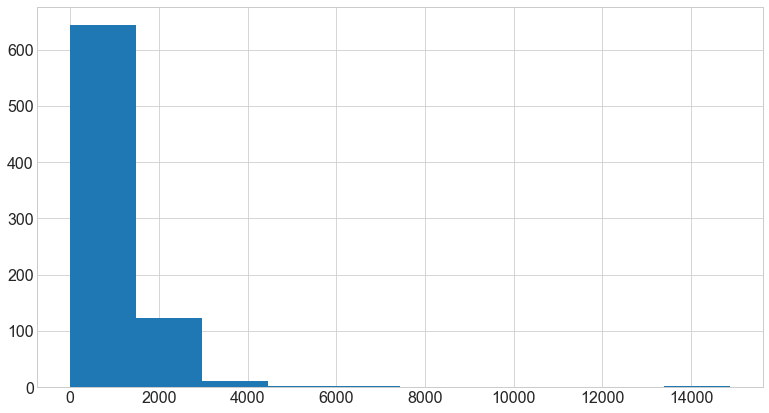

In [191]:
# Viz the distribution of the accessing numbers
df['user_id'].value_counts(dropna=False).hist()

In [192]:
# Take a look at the student id 11
df[df.user_id == 11]

,request_method,user_id,cohort_id,ip
timestamp,,,,
2018-01-26 10:14:47,/,11,1.0,97.105.19.61
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61
2018-01-26 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1.0,97.105.19.61
2018-01-26 11:46:39,appendix,11,1.0,97.105.19.61
...,...,...,...,...
2020-11-02 16:22:12,nlp/explore,11,28.0,76.185.145.231
2020-11-02 16:42:02,anomaly-detection/overview,11,28.0,76.185.145.231
2020-11-02 16:42:02,anomaly-detection/AnomalyDetectionCartoon.jpeg,11,28.0,76.185.145.231


In [193]:
# Take a look at the student id 
df[df.user_id == 64]

,request_method,user_id,cohort_id,ip
timestamp,,,,
2018-01-29 13:50:57,/,64,1.0,97.105.19.61
2018-01-29 13:51:00,mkdocs/search_index.json,64,1.0,97.105.19.61
2018-01-29 13:51:04,mysql/users,64,1.0,97.105.19.61
2018-01-30 10:13:09,/,64,1.0,97.105.19.61
2018-01-30 10:13:12,spring,64,1.0,97.105.19.61
...,...,...,...,...
2020-10-29 16:59:30,mysql/group-by,64,28.0,76.25.25.4
2020-10-29 16:59:38,mysql/aliases,64,28.0,76.25.25.4
2020-10-29 16:59:58,mysql/group-by,64,28.0,76.25.25.4


In [194]:
# Take a look at the student id 
df[df.user_id == 53]

,request_method,user_id,cohort_id,ip
timestamp,,,,
2018-01-28 18:48:19,index.html,53,14.0,67.10.161.55
2018-01-28 18:48:24,html-css,53,14.0,67.10.161.55
2018-01-28 18:49:20,javascript-i,53,14.0,67.10.161.55
2018-01-28 18:49:23,javascript-i/conditionals,53,14.0,67.10.161.55
2018-01-28 18:50:41,javascript-i/conditionals,53,14.0,67.10.161.55
...,...,...,...,...
2020-11-02 09:09:53,examples/javascript/dom-query-js.html,53,28.0,67.10.174.56
2020-11-02 15:27:42,appendix/slides,53,28.0,67.10.174.56
2020-11-02 16:09:40,index.html,53,28.0,67.10.174.56


In [195]:
# How many unique values in column 4?
df.cohort_id.nunique() # 40 unique values in cohort id

40

In [196]:
# Which cohort id has the highest counts of accessing?

df['cohort_id'].value_counts(dropna=False).head(5)

28.0    60315
NaN     44840
33.0    40168
29.0    37548
53.0    36047
Name: cohort_id, dtype: int64

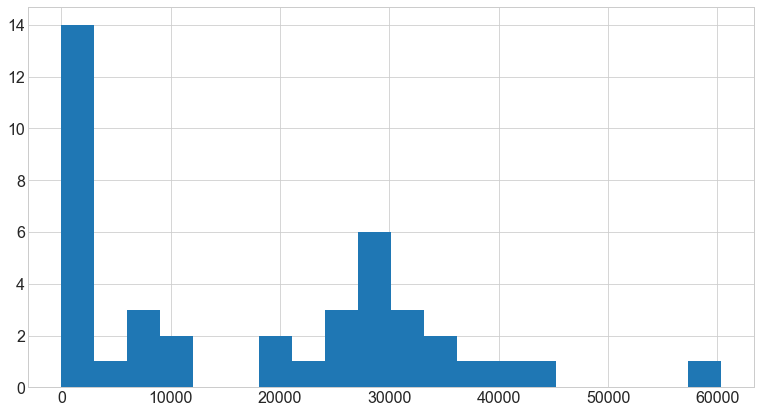

In [197]:
# Viz the distribution of the counts of accessing by counts

df['cohort_id'].value_counts(dropna=False).hist(bins=20)

### Focus on cohort where my ip belongs to: cohort 59

In [198]:
# Create the dataframe for cohort 59

df_59 = df[(df.cohort_id == 59)]
df_59.head()

,request_method,user_id,cohort_id,ip
timestamp,,,,
2020-07-13 14:34:44,/,678,59.0,76.201.20.193
2020-07-13 14:37:22,/,679,59.0,24.28.146.155
2020-07-13 14:38:28,/,680,59.0,136.50.56.155
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59.0,24.28.146.155
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59.0,24.28.146.155


In [199]:
# Print the data range
print('Date Range:', df_59.index.min(), 'to', df_59.index.max())

Date Range: 2020-07-13 14:34:44 to 2020-11-02 15:52:23


In [200]:
# Any missing values?
df_59.isna().sum() # No missing values

request_method    0
user_id           0
cohort_id         0
ip                0
dtype: int64

### Compute entropy of each columns

In [201]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [202]:
# Compute entropy of cohort id
compute_entropy(df_59.cohort_id) # is 0 since there is only one unique value in this column. 

0

In [203]:
# Compute entropy of request page
compute_entropy(df_59.request_method)

4.770190297987762

In [204]:
# Compute entropy of user_id
compute_entropy(df_59.user_id)

3.0193491002050257

In [205]:
# Compute entropy of ip
compute_entropy(df_59.ip)

3.4316749297604687

### Target Varible: Hits per hour in cohort 59
- Should be the same no matter which col is used, except corhort id

In [206]:
# Resample by hours and count the hits.
df_59.resample('H').user_id.size()

timestamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
                       ..
2020-11-02 11:00:00     5
2020-11-02 12:00:00    11
2020-11-02 13:00:00    14
2020-11-02 14:00:00    10
2020-11-02 15:00:00    32
Freq: H, Name: user_id, Length: 2690, dtype: int64

In [207]:
df_59.resample('H').request_method.size()

timestamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
                       ..
2020-11-02 11:00:00     5
2020-11-02 12:00:00    11
2020-11-02 13:00:00    14
2020-11-02 14:00:00    10
2020-11-02 15:00:00    32
Freq: H, Name: request_method, Length: 2690, dtype: int64

In [208]:
df_59.resample('H').ip.size()

timestamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
                       ..
2020-11-02 11:00:00     5
2020-11-02 12:00:00    11
2020-11-02 13:00:00    14
2020-11-02 14:00:00    10
2020-11-02 15:00:00    32
Freq: H, Name: ip, Length: 2690, dtype: int64

In [209]:
# Quick sanity check on days_between
days_between = df_59.index.max() - df_59.index.min()
days_between

Timedelta('112 days 01:17:39')

In [210]:
# Quick sanity check on days_between
days_between = 2690/24
days_between

112.08333333333333

In [211]:
# Store target in a dataframe

df_59_hits = df_59.resample('H').user_id.size()
print(df_59_hits.shape)
df_59_hits.head()

(2690,)


timestamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
Freq: H, Name: user_id, dtype: int64

### Split into Train/Test

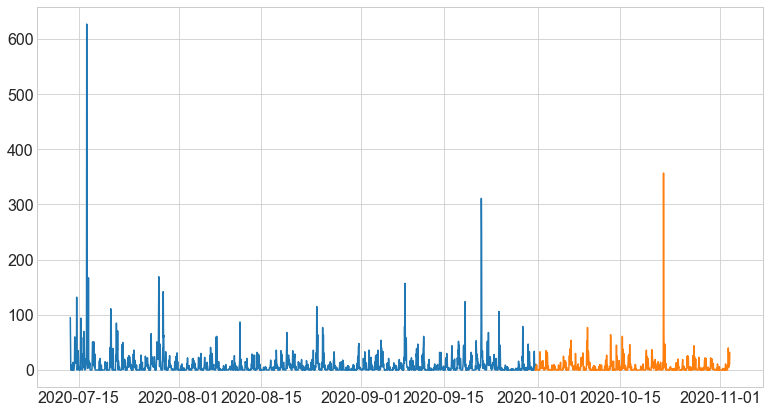

In [212]:
start_date_train = df_59_hits.head(1).index[0]
end_date_train = '2020-09-30 13:00:00'
start_date_test = '2020-09-30 14:00:00'

train = df_59_hits[:end_date_train]
test = df_59_hits[start_date_test:]

plt.plot(train)
plt.plot(test)
plt.show()

In [213]:
train.tail()

timestamp
2020-09-30 09:00:00    15
2020-09-30 10:00:00    34
2020-09-30 11:00:00     3
2020-09-30 12:00:00    11
2020-09-30 13:00:00     0
Freq: H, Name: user_id, dtype: int64

In [214]:
test.head()

timestamp
2020-09-30 14:00:00    0
2020-09-30 15:00:00    3
2020-09-30 16:00:00    6
2020-09-30 17:00:00    0
2020-09-30 18:00:00    1
Freq: H, Name: user_id, dtype: int64

In [215]:
test.tail()

timestamp
2020-11-02 11:00:00     5
2020-11-02 12:00:00    11
2020-11-02 13:00:00    14
2020-11-02 14:00:00    10
2020-11-02 15:00:00    32
Freq: H, Name: user_id, dtype: int64

In [216]:
# Store target in a variable named y for ease of access

y = train
print(y.shape)
y.head()

(1896,)


timestamp
2020-07-13 14:00:00    95
2020-07-13 15:00:00    36
2020-07-13 16:00:00     0
2020-07-13 17:00:00     3
2020-07-13 18:00:00     3
Freq: H, Name: user_id, dtype: int64

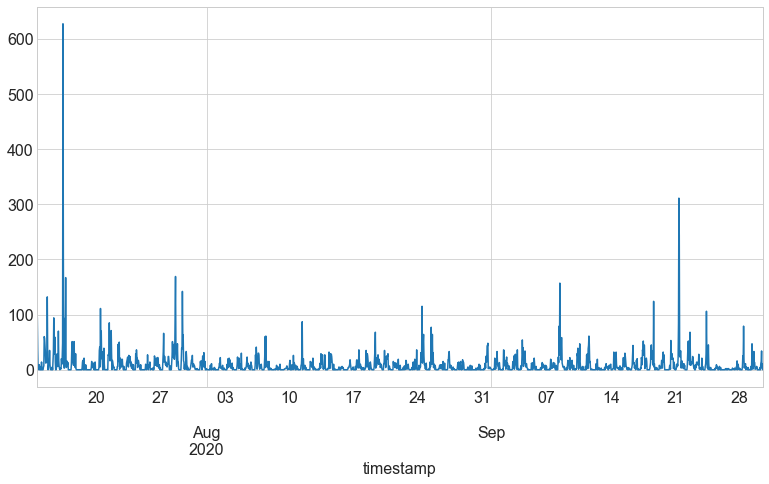

In [217]:
# Viz our target variable over time

y.plot()

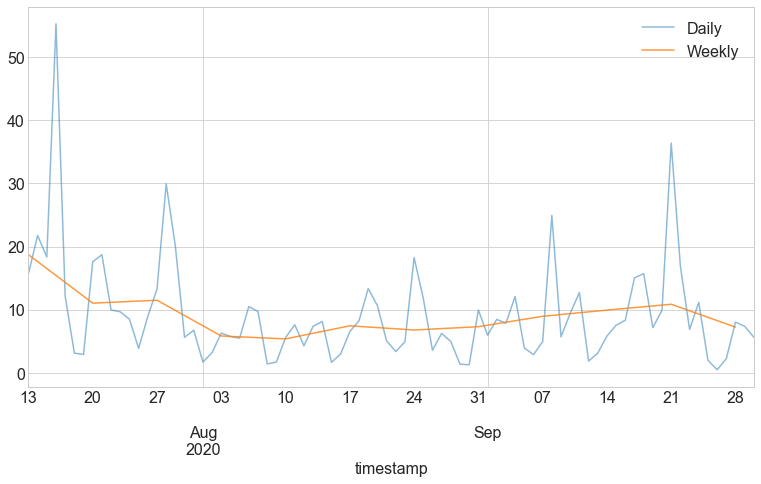

In [218]:
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
plt.legend()

### Autocorrealtion Plot - time unit: Day and Week
- No seaonablity was found

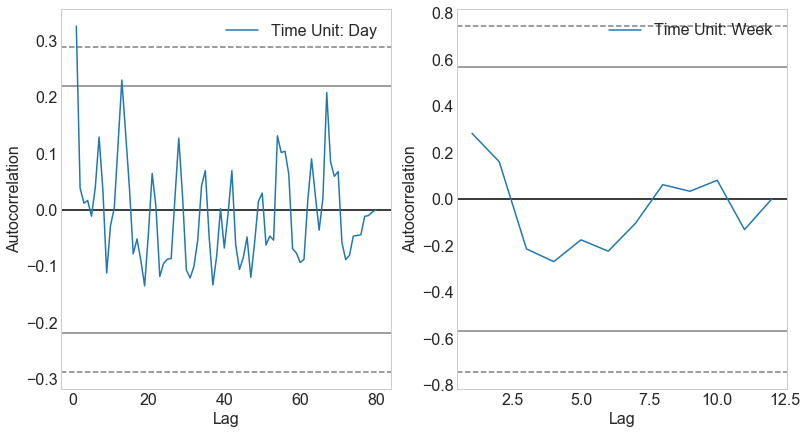

In [219]:
fig, (ax1, ax2) = plt.subplots(1, 2)

pd.plotting.autocorrelation_plot(train.resample('D').mean(), ax=ax1, label='Time Unit: Day')
pd.plotting.autocorrelation_plot(train.resample('W').mean(), ax=ax2, label='Time Unit: Week')
plt.legend()

### Simple Moving Average

In [220]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

In [221]:
short_rolling.head(13)

timestamp
2020-07-13 14:00:00          NaN
2020-07-13 15:00:00          NaN
2020-07-13 16:00:00          NaN
2020-07-13 17:00:00          NaN
2020-07-13 18:00:00          NaN
2020-07-13 19:00:00          NaN
2020-07-13 20:00:00          NaN
2020-07-13 21:00:00          NaN
2020-07-13 22:00:00          NaN
2020-07-13 23:00:00          NaN
2020-07-14 00:00:00          NaN
2020-07-14 01:00:00    14.250000
2020-07-14 02:00:00     6.333333
Freq: H, Name: user_id, dtype: float64

In [222]:
long_rolling[20:30]

timestamp
2020-07-14 10:00:00          NaN
2020-07-14 11:00:00          NaN
2020-07-14 12:00:00          NaN
2020-07-14 13:00:00    16.916667
2020-07-14 14:00:00    13.875000
2020-07-14 15:00:00    12.916667
2020-07-14 16:00:00    18.416667
2020-07-14 17:00:00    19.708333
2020-07-14 18:00:00    19.583333
2020-07-14 19:00:00    19.375000
Freq: H, Name: user_id, dtype: float64

Text(0, 0.5, 'hits')

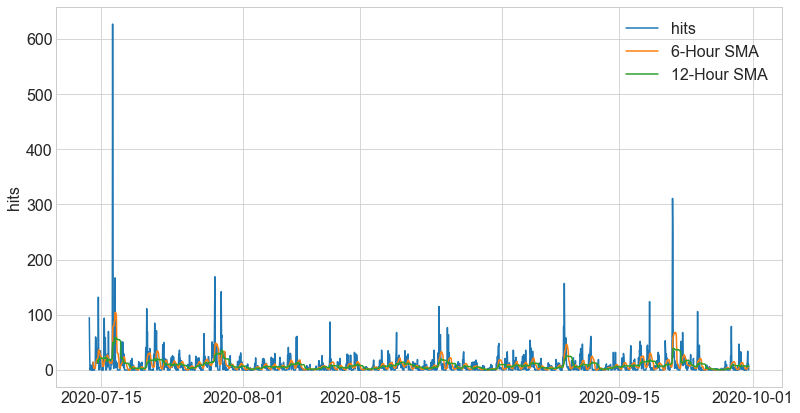

In [223]:
fig, ax = plt.subplots()

ax.plot(train.index, 
        train,
        label='hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('hits')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

### Expotential Moving Average

In [224]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short.tail()

timestamp
2020-09-30 09:00:00    5.256390
2020-09-30 10:00:00    9.678484
2020-09-30 11:00:00    8.651025
2020-09-30 12:00:00    9.012406
2020-09-30 13:00:00    7.625882
Freq: H, Name: user_id, dtype: float64

In [225]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
ema_long.tail()

timestamp
2020-09-30 09:00:00    5.357620
2020-09-30 10:00:00    7.649011
2020-09-30 11:00:00    7.277090
2020-09-30 12:00:00    7.574922
2020-09-30 13:00:00    6.968929
Freq: H, Name: user_id, dtype: float64

Text(0, 0.5, 'hits')

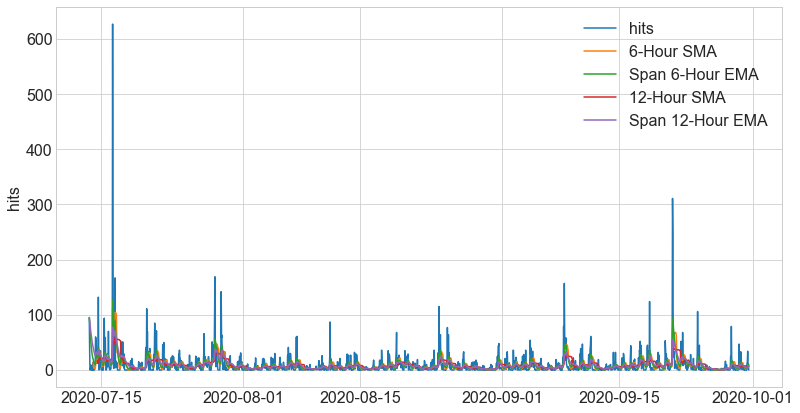

In [226]:
fig, ax = plt.subplots()

ax.plot(train.index, 
        train,
        label='hits')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('hits')

## Bollinger Bands %B
### Bollinger Bands
- a volatility indicator and commonly used in stock market trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.
### Midband
- The Exponential Moving Average
- midband = train.ewm(span=30).mean()
### Upper & Lower Band
- UB/LB = Midband +/- stdev * K
- stdev = train.ewm(span=30).std()
- K = the number of standard deviations to go up and down from the EMA
### %b, Percent Bandwidth
- Shows where the last value sits in relation to the bands
- $\%b = \frac{last-LB}{UB-LB}$
- %b > 1 => point lies above UB
- %b < 0 => point lies below LB
- %b == .5 => point lies on the midband.
### Bandwidth
- The width of the bands
- $Bandwidth = \frac{(UB-LB)}{Midband}$

In [227]:
# Set the window span
span = 24

# compute midband
midband = train.ewm(span=span, adjust=False).mean()
midband

timestamp
2020-07-13 14:00:00    95.000000
2020-07-13 15:00:00    90.280000
2020-07-13 16:00:00    83.057600
2020-07-13 17:00:00    76.652992
2020-07-13 18:00:00    70.760753
                         ...    
2020-09-30 09:00:00     5.357620
2020-09-30 10:00:00     7.649011
2020-09-30 11:00:00     7.277090
2020-09-30 12:00:00     7.574922
2020-09-30 13:00:00     6.968929
Freq: H, Name: user_id, Length: 1896, dtype: float64

In [228]:
# compute exponential stdev
stdev = train.ewm(span=span).std()
stdev

timestamp
2020-07-13 14:00:00          NaN
2020-07-13 15:00:00    41.719300
2020-07-13 16:00:00    47.617694
2020-07-13 17:00:00    42.890845
2020-07-13 18:00:00    38.583669
                         ...    
2020-09-30 09:00:00     8.907779
2020-09-30 10:00:00    11.662173
2020-09-30 11:00:00    11.259915
2020-09-30 12:00:00    10.849299
2020-09-30 13:00:00    10.615905
Freq: H, Name: user_id, Length: 1896, dtype: float64

In [229]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

ub

timestamp
2020-07-13 14:00:00           NaN
2020-07-13 15:00:00    215.437900
2020-07-13 16:00:00    225.910681
2020-07-13 17:00:00    205.325528
2020-07-13 18:00:00    186.511759
                          ...    
2020-09-30 09:00:00     32.080958
2020-09-30 10:00:00     42.635531
2020-09-30 11:00:00     41.056835
2020-09-30 12:00:00     40.122819
2020-09-30 13:00:00     38.816644
Freq: H, Name: user_id, Length: 1896, dtype: float64

Text(0, 0.5, 'hits')

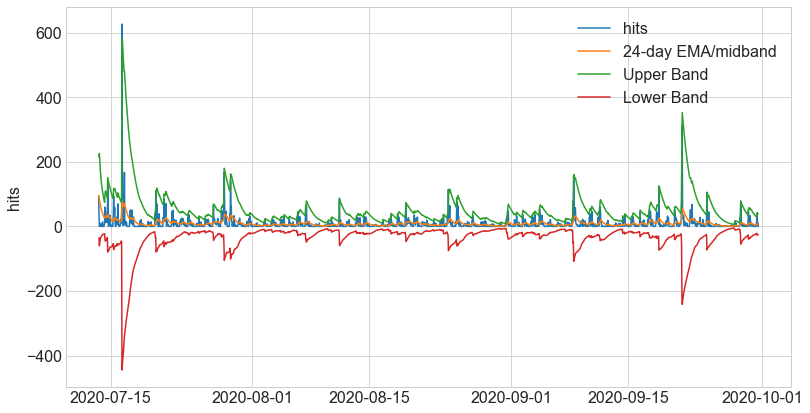

In [230]:
fig, ax = plt.subplots()

ax.plot(train.index, 
        train,
        label='hits')

ax.plot(train.index, 
        midband, 
        label = '24-day EMA/midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('hits')

### Where do you think we will have a %b > 1?
- Compute %b
- $\%b = \frac{last-LB}{UB-LB}$

In [231]:
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['hits', 'midband', 'ub', 'lb']
train.tail()

,hits,midband,ub,lb
timestamp,,,,
2020-09-30 09:00:00,15,5.357620,32.080958,-21.365718
2020-09-30 10:00:00,34,7.649011,42.635531,-27.337510
2020-09-30 11:00:00,3,7.277090,41.056835,-26.502655
2020-09-30 12:00:00,11,7.574922,40.122819,-24.972974
2020-09-30 13:00:00,0,6.968929,38.816644,-24.878787


In [233]:
train['pct_b'] = (train['hits'] - train['lb'])/(train['ub'] - train['lb'])

In [234]:
train[train['pct_b']>1]

,hits,midband,ub,lb,pct_b
timestamp,,,,,
2020-07-16 09:00:00,627,66.439590,577.815006,-444.935827,1.048091
2020-07-20 11:00:00,111,15.851212,110.598679,-78.896256,1.002118
2020-08-11 10:00:00,87,11.926708,83.401089,-59.547673,1.025176
2020-08-24 11:00:00,115,18.310511,112.044224,-75.423203,1.015767
2020-09-08 09:00:00,79,12.384795,75.819877,-51.050287,1.025066
2020-09-14 08:00:00,32,5.216640,31.948481,-21.515200,1.000964
2020-09-21 10:00:00,311,39.240564,293.654278,-215.173150,1.034090
2020-09-24 10:00:00,106,15.501522,104.016686,-73.013642,1.011203
2020-09-28 11:00:00,79,10.778169,76.253119,-54.696780,1.020977
